## UNT MODELS for DARPA Hurdle 3 

Given that a Random Guess does not perform well enough to pass the 3rd hurdle of the DARPA Sharing Spectrum Competition, Then a more intelligent solution is required. In this document I propose 3 posible solutions for this 3rd hurdle. 




#### Solution 1: Generic Random Forest Predictor given the past behaviour

   This is the fastest and one of the easiest methods I could think of. Given the last outputs of the Player and the DARPA player let a Random Forest predict the next output given a sequence of previous outputs. 
   
   Input sequences may be M-length or Fixed-Length (e.g. 100 samples) 
     
   Output of the estimator is a M-length-1 vector with the probabilities of each posible output. From here we select the most Probable output as our prediction and the Least probable output as out selection 
   


In [1]:
# import UNT_hurdle3.py  for training and simulation 

import UNT_hurdle3 as h3 
import pandas as pd 
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
import itertools


class RFPlayer:
    ''' A Simple class that simulate a RandomForest base Player for the #3 Hurdle of the DARPA Competition  '''
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier                       
        
        
        
    def __init__ (self, N,retrain=500, seq_size = 1):
        self._type = "RF"
        self.N = N                        ## Random N-states (NOT USED)
        self.M = N                        ##  M-outputs
        self.clf = RandomForestClassifier(n_estimators=25) ## Our estimator
        self.retrain = retrain            ## Retrain after #retrain turns of the game
        self.input_size = seq_size        ## How many lags should we include
        self.Dataset = self.createDataset(seq_size)
        self.record = pd.DataFrame( columns=['Player_Last','Last','pred','Player_Play'])
        self.feature = []
        self.turn = 0
        self.PlayerLast = -1
                            
        
        # In order to get A -> choice from Q column
    def start(self):

        D,P = [np.random.choice(range(1,self.M)),np.random.choice(range(1,self.M))]
        self.Prev_D = D
        return D,P
            
    
    def step(self, reward,Last):
        
        self.turn = self.turn +1
        
        if self.turn < self.retrain:
            PlayerPlay,pred = self.start()
                    
        else:
            # check if is time to train 
            if self.turn%self.retrain == 0:
                # Train
                self.Train()
                    
            PlayerPlay,pred = self.predict(Last)            
                 
        self.appendData(Last,self.PlayerLast, pred,PlayerPlay)

        self.PlayerLast = PlayerPlay
        
        return [PlayerPlay,pred]
    
    
    def createDataset(self, lags):
        Player_names = ['Player_lag_{0} '.format(s) for s in range(1,lags)]
        Bot_names = ["Bot_lag_{0}".format(s) for s in range(1,lags)]
        cols = np.concatenate([['Player_Play','Last'],Player_names,Bot_names], axis=0)
        
                                           
        df = pd.DataFrame(columns=['Player_Play','Last'], dtype = 'int32')
        
        return df        
    
    def FormatData(self):
        
        #tdf = pd.concat([self.record.Player_Last.shift(n) for n in range(1,self.input_size)], axis=1)
        #tdf.columns = ['Player_lag_{0} '.format(s) for s in range(1,self.input_size)]
        #ttdf = pd.concat([self.record.Last.shift(n) for n in range(1,self.input_size) ], axis=1)
        #ttdf.columns = ['Bot_lag_{0} '.format(s) for s in range(1,self.input_size)]

        #print ttdf 
        #df = pd.concat([self.record,tdf,ttdf], axis=1)
        
        #return df
        return self.record
    
    def appendData(self, Last, Player_Last,pred,Play):
                
        self.record = self.record.append(pd.DataFrame([[Last, Player_Last,pred,Play]], columns=['Last','Player_Last','pred','Player_Play']),ignore_index=True)
        self.Dataset = self.FormatData()
        
    def Train(self):                
        
        print "Training.. "
        df = self.Dataset.drop('pred',1).drop('Player_Last',1).copy()
        df['Label'] = self.Dataset.Last.shift(-1)  
        df = df.dropna(axis=0) # Remove NA rows 
        rf = RandomForestClassifier(n_estimators=20) # Basic Clf
        
        #run grid search
        kf = KFold(df.shape[0],n_folds=3)
        grid_search = GridSearchCV(rf,{})  
        
        
        x = df.drop('Label',1)
        y = df.Label
        self.clf = grid_search.fit(x,y)            
        
        #print "Train ACC:", accuracy_score(y, self.clf.predict(x))
        return True    
        
        
    def predict(self,Last):
        
        good = False
        l = self.Dataset.Last.unique()
        l.sort(axis=0)
        
        for i in range(1,11):
            play = np.random.randint(0,self.N,size=1)[0]              
            
            proba = self.clf.predict_proba(pd.DataFrame([[play,Last]], columns=['Player_Play','Last']))
            pred = l[proba.argmax()]
            
            if play != pred:
                good = True
                break
        
        if not good:
            print "Not Good"
            play,pred = np.random.randint(0,self.N,size=2)               

        
        return play,pred # P = More Likely, D = Less Likely
    
    def restart(self):
        print "Restarting.. "
        self.__init__(self.N,self.retrain,self.input_size)
        return True
        
        


In [2]:
class JorgePlayer:
    ''' 
    A Simple class that simulate a base Player based on Jorge's prediction
    for the #3 Hurdle of the DARPA Competition
    '''
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier 
    import itertools
   
    def __init__ (self, N,retrain=500):
        
        self._type = "Jorge"
        self.N = N                        ## Random N-states (NOT USED)
        self.M = N                        ##  M-outputs        
        self.retrain = retrain            ## Retrain after #retrain turns of the game        
        self.Dataset, self.BestPlayTable = self.createDataset()
        self.record = pd.DataFrame( columns=['Player_Last','Last','pred','Player_Play'])
        
        self.turn = 0
        self.PlayerLast = -1
                                    
    def start(self):

        D,P = [np.random.choice(range(self.M)),np.random.choice(range(self.M))]
        self.Prev_D = D
        return D,P
        
    def step(self,reward ,Last):
        
        self.turn = self.turn +1
        
        if self.turn < self.retrain:
            PlayerPlay,pred = self.start()
                    
        else:
            # check if is time to train 
            if self.turn%self.retrain == 0:
                # Train
                self.Train()
                    
            PlayerPlay,pred = self.predict(Last)            
                 
        self.appendData(Last,self.PlayerLast, pred,PlayerPlay)

        self.PlayerLast = PlayerPlay
        
        return [pred,PlayerPlay]
    
    
    def updateBestPlay(self,Player_Last, Last):
        if PlayerPlay == Last:
            self.BestPlayTable[self.BestPlayTable.index == Player_Last] = self.BestPlayTable[self.BestPlayTable.index == Player_Last] -1
        else:
            self.BestPlayTable[self.BestPlayTable.index == Player_Last] = self.BestPlayTable[self.BestPlayTable.index == Player_Last] +1
            
    
    def updateDataset(self):  
        
        df= self.record
        df['Label'] = df.Last.shift(-1)
        df['prob'] = df.Last.shift(-1)
        self.Dataset =df.groupby(['Player_Play','Last']).Label.agg(lambda x:x.value_counts().index[0]).reset_index()                                
        dataset2 = df.groupby(['Player_Play','Last']).prob.agg(lambda x:np.float(x.value_counts().values[0])/x.value_counts().values.sum()).reset_index()
        self.Dataset = self.Dataset.merge(dataset2, on=['Player_Play','Last'])  
        
    def createDataset(self):                
        
        df = pd.DataFrame(columns=['Player_Play','Last','pred','Player_Last','pred'])
        #table to keep score of our best plays 
        table = pd.DataFrame(index=range(self.N), columns=['Points'])
        return df, table
    
    
    def appendData(self, Last, Player_Last,pred,Play):
                
        self.record = self.record.append(pd.DataFrame([[Last, Player_Last,pred,Play]], columns=['Last','Player_Last','pred','Player_Play']),ignore_index=True)
        
    def Train(self):                
        
        print "Training.. "
        # Training is really update the Dataset
        self.updateDataset()
        
        return True    

    
    def predict(self,Last):
        
        good = False
        for i in range(1,11):
            play = self.Dataset[(self.Dataset.Last == Last) & (self.Dataset.Player_Play != self.Dataset.Label)]\
            .sort(columns= 'prob', ascending = False)\
            .head(1).Player_Play.iloc[0]
            
            pred = self.Dataset[(self.Dataset.Player_Play == play) & (self.Dataset.Last == Last)].Label.iloc[0]
            
            if play != pred:
                good = True
                break
        
        if not good:
            play,pred = np.random.randint(0,self.N,size=2)               

        
        return play,pred # P = More Likely, D = Less Likely 
        
    def restart(self):
        print "Restarting.. "
        self.__init__(self.N,self.retrain)
        return True

Total MC Runs 10
Total Turns 30000
Restarting.. 
Training.. 


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:91: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
UNT_hurdle3.py:237: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cum_sums = self.cum_sum_mat[self.state, observation, :]


Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
CPU times: user 20min 14s, sys: 15.7 s, total: 20min 29s
Wall time: 20min 31s


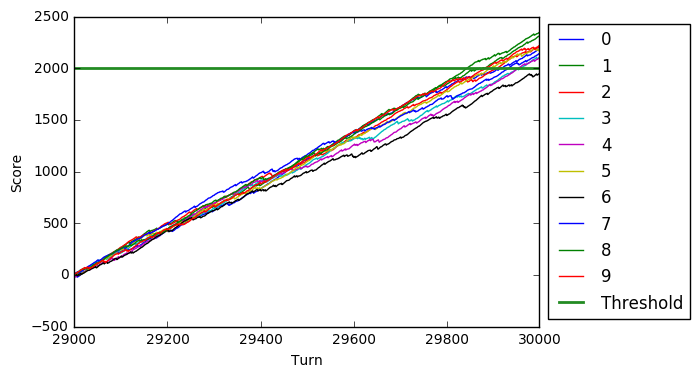

In [3]:
import UNT_hurdle3 as h3
import pandas as pd
import numpy as np

P1 = h3.DarpaPlayer(10,probs=0.6)

RFP = JorgePlayer(10,retrain=10000)
#RFP = h3.JorgePlayer(10,retrain=10000)

test = h3.Hurdle_MC(P1,RFP,total_turns = 30000, total_runs=10)

print "Total MC Runs", test.mc_runs
print "Total Turns", test.turns
%time test.simulate()

Total MC Runs 10
Total Turns 30000
Restarting.. 
Training.. 


UNT_hurdle3.py:355: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  .sort(columns= 'prob', ascending = False)\


Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
Restarting.. 
Training.. 
Training.. 
CPU times: user 20min 17s, sys: 2.66 s, total: 20min 19s
Wall time: 20min 21s


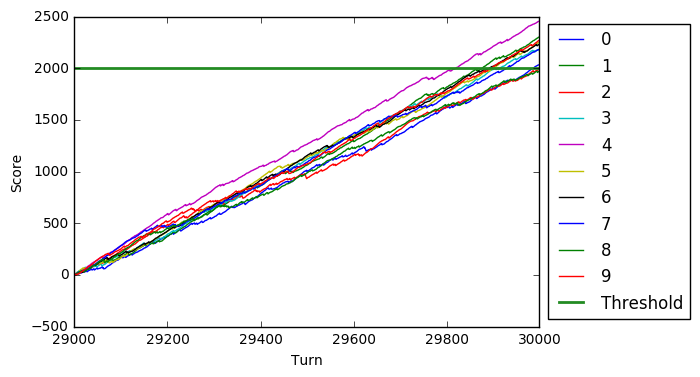

In [4]:
import UNT_hurdle3 as h3

P1 = h3.DarpaPlayer(10,probs=0.6)

#RFP = JorgePlayer(10,retrain=10000)
RFP = h3.JorgePlayer(10,retrain=10000)

test = h3.Hurdle_MC(P1,RFP,total_turns = 30000, total_runs=10)

print "Total MC Runs", test.mc_runs
print "Total Turns", test.turns
%time test.simulate()

In [ ]:
df= test.PlayerA.Dataset
df.sort('prob', ascending=False).head(30)


In [ ]:
print test.PlayerD.transition_mat[0,0,:]
df[(df.Player_Play == 1) & (df.Last == 1)].Label.value_counts()

#### Solution 2: eXtreme Gradient Bosting Machine (XGB)  given the past behaviour

   This is an evolution of the first method, However it requires the instalation of XGB in the docker_container. Same procedure as the Solution 1 
   
   Input sequences may be M-length or Fixed-Length (e.g. 100 samples) 
     
   Output of the estimator is a M-length-1 vector with the probabilities of each posible output. From here we select the most Probable output as our prediction and the Least probable output as out selection 

#### Solution 3: Long Short Term Memory Neural Networks on Tensorflow (The good stuff!)  given the past behaviour

   This is completly different approach from the previous models. (TODO: Add more info for LSTM if needed) 
   
           
   Output of the estimator is a M-length-1 vector with the probabilities of each posible output. From here we select the most Probable output as our prediction and the Least probable output as out selection 
      

In [ ]:
print test.PlayerA.clf.predict_proba(test.PlayerA.Dataset.drop('pred',1)[-5:])
print test.PlayerA.clf.predict(test.PlayerA.Dataset.drop('pred',1)[-5:])


In [ ]:
l = test.PlayerA.Dataset.Last.unique()
l.sort(axis=0)
print l

proba = test.PlayerA.clf.predict_proba(test.PlayerA.Dataset.drop('pred',1)[-1:])
pred = test.PlayerA.clf.predict(test.PlayerA.Dataset.drop('pred',1)[-1:])

print "More Likely: ", l[proba.argmax()], " Pred: ", pred
print "Less Likely: ", l[proba.argmin()], " Pred: ", pred, " Probas: ", proba

In [ ]:
proba.argmax()